# Model Training: Forwards - XGBRegressor

The task here will be to train a model to predict that value of NHL players who play the Forward position. Choice of features is based on the EDA done in 01_F_EDA.ipynb (Folder 4_ExploratoryDataAnalysis)

## Import our data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

In [ ]:
# Load in our data
filepath = '../../Data/entitiesResolved/merged_data_final.csv'
data = pd.read_csv(filepath)

## Features to try:

Recall that the EDA done revealed that we should try to use the following features:

1. TOI/GP
2. XGF/60 - and possibly combining it with SCF/60, FF/60, HDCF/60, CF/60, SF/60, and MDCF/60 to create a new feature.
3. GF/60
4. TOTAL ASSISTS/60 - But possibly using FIRST ASSISTS/60 and SECOND_ASSISTS/60 instead.
5. GOALS/60
6. Handedness

In [671]:
# Select all rows were the 'Position' is 'c' or 'c,l' or 'c,r'
centers = data[data['POSITION'].isin(['c', 'c, l', 'c, r'])]

# Select only players with 65 or more games played
centers = centers[(centers['GP'] >= 60)]

# Select only players with a salary cap percentage in the interquartile range
q1 = centers['SALARY CAP PERCENTAGE'].quantile(0.25)
q3 = centers['SALARY CAP PERCENTAGE'].quantile(0.75)
iqr = q3 - q1

# Remove outliers
test_train_data = centers[(centers['SALARY CAP PERCENTAGE'] >= q1 - 1.5 * iqr) & (centers['SALARY CAP PERCENTAGE'] <= q3 + 1.5 * iqr)]

# Top abs features
top_abs_features = ['ON\xa0THE\xa0FLY STARTS/60',
                    'OFF.\xa0ZONE FACEOFFS/60',
                    'HDGF/60']

# Select the features we want to use
pca_features = ['SCF/60', 'FF/60', 'HDCF/60', 'CF/60', 'SF/60', 'MDCF/60', 'XGF/60', 'GF/60'] + top_abs_features
numerical_features = ['TOTAL ASSISTS/60', 'GOALS/60'] + pca_features # 'TOI/GP', 'FIRST ASSISTS/60', 'SECOND ASSISTS/60'
categorical_features = []

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('pca', PCA(n_components=1), pca_features),
        ('cat', OneHotEncoder(), categorical_features)
    ]
)

# Advice regard how to prevent overfitting with XBGoost found here: https://tomatofox.wordpress.com/2020/09/21/xgboost-overfitting/
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', XGBRegressor(objective='reg:squarederror', random_state=42, n_estimators=2000, max_depth=5, reg_lambda=2, eta=0.01))]) # Grid Search optimal n_estimators=500, max_depth=5, reg_lambda=1, eta=0.01

X = test_train_data.drop('SALARY CAP PERCENTAGE', axis=1)
y = test_train_data['SALARY CAP PERCENTAGE']

In [672]:
# # Using grid search, find the best n_estimators for the model
# param_grid = {
#     'regressor__n_estimators': [100, 500, 1000],
#     'regressor__max_depth' : [5, 15, 25],
#     'regressor__reg_lambda': [0.01, 0.1, 1],
#     'regressor__eta': [0.001, 0.01, 0.1],
# }
# search = GridSearchCV(pipeline, param_grid, n_jobs=-1, cv=3, scoring='neg_mean_squared_error')
# search.fit(X, y)

# # Output the best parameters
# print("Best parameter (CV score=%0.3f):" % search.best_score_)
# print(search.best_params_)

In [673]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.0006620550092130153


In [674]:
# # View the coefficients of the model with the name of the features
# features = numerical_features + categorical_features
# coefficients = pipeline.named_steps['regressor'].coef_
# coefficients = [round(coef, 5) for coef in coefficients]
# print(dict(zip(features, coefficients)))

In [675]:
def convert_to_dollars(df, col):
    return df[col].map('${:,.2f}'.format)

def invert_convert_to_dollars(df, col):
    return df[col].str.replace('$', '').str.replace(',', '').astype(float)


In [676]:
# Create a feature column in Centers for the predicted salary
centers['PRED_SALARY_PERCENTAGE'] = pipeline.predict(centers)

# Create a column for the actual predicted salary
centers['PRED_AAV'] = centers['PRED_SALARY_PERCENTAGE'] * centers['SALARY CAP']
centers['PRED_AAV'] = centers['PRED_AAV'].astype(int)

# Compute the differential between the predicted and actual salary
centers['DIFF'] = centers['PRED_AAV'] - centers['AAV']

# Convert to dollars
centers['PRED_AAV'] = convert_to_dollars(centers, 'PRED_AAV')
centers['AAV'] = convert_to_dollars(centers, 'AAV')
centers['DIFF'] = convert_to_dollars(centers, 'DIFF')

Text(0.5, 1.0, 'Distribution of Predicted Salary Percentage for Centers')

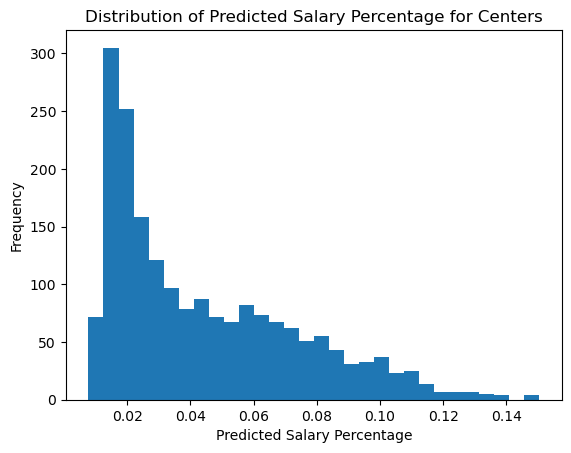

In [677]:
# Plot the distribution of PRED_SALARY_PERCENTAGE
plt.hist(centers['PRED_SALARY_PERCENTAGE'], bins=30)
plt.xlabel('Predicted Salary Percentage')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Salary Percentage for Centers')

In [665]:
# Select the top 15 centers by predicted salary
top_centers = centers[centers['SEASON'] == '2023-24'].sort_values(by='PRED_SALARY_PERCENTAGE', ascending=False).head(15)
display_features = ['PLAYER', 'SEASON', 'GP'] + numerical_features + categorical_features + ['SALARY CAP PERCENTAGE', 'PRED_SALARY_PERCENTAGE', 'AAV', 'PRED_AAV']
top_centers[display_features]

,PLAYER,SEASON,GP,TOTAL ASSISTS/60,GOALS/60,SCF/60,FF/60,HDCF/60,CF/60,SF/60,MDCF/60,XGF/60,GF/60,ON THE FLY STARTS/60,OFF. ZONE FACEOFFS/60,HDGF/60,SALARY CAP PERCENTAGE,PRED_SALARY_PERCENTAGE,AAV,PRED_AAV
12698,nathan mackinnon,2023-24,69,2.85,1.60,42.99,60.59,17.60,82.75,42.80,33.85,4.72,6.04,30.10,35.92,3.04,0.150898,0.147736,"$12,600,000.00","$12,335,963.00"
12328,connor mcdavid,2023-24,65,3.68,1.11,46.60,61.66,20.45,82.71,44.07,34.86,5.48,6.12,30.89,30.12,3.38,0.149701,0.147122,"$12,500,000.00","$12,284,722.00"
12227,auston matthews,2023-24,67,1.36,2.42,42.82,57.34,19.50,78.20,38.91,31.09,4.64,5.31,34.66,27.40,2.63,0.139404,0.137511,"$11,640,250.00","$11,482,197.00"
12528,jonathan huberdeau,2023-24,67,1.75,0.46,35.74,52.46,14.19,74.52,36.05,28.73,3.98,3.29,42.63,31.52,1.65,0.125749,0.123696,"$10,500,000.00","$10,328,579.00"
12518,john tavares,2023-24,66,1.57,1.16,42.83,58.03,19.54,79.89,41.26,31.04,4.89,4.39,36.66,29.09,2.02,0.131737,0.121096,"$11,000,000.00","$10,111,481.00"
12175,aleksander barkov,2023-24,62,2.38,0.89,40.55,56.89,17.38,79.42,39.51,30.90,4.68,4.80,34.76,27.33,2.77,0.119760,0.113626,"$10,000,000.00","$9,487,757.00"
12258,brayden point,2023-24,69,1.64,1.73,39.29,55.31,15.36,75.65,38.26,31.91,4.33,5.41,37.22,29.17,2.42,0.113772,0.110400,"$9,500,000.00","$9,218,370.00"
12218,anze kopitar,2023-24,69,1.65,1.03,29.97,46.44,12.55,65.60,31.93,23.22,3.54,4.15,35.37,25.01,2.14,0.119760,0.109012,"$10,000,000.00","$9,102,470.00"
12590,leon draisaitl,2023-24,67,2.37,1.51,41.70,57.15,18.25,75.91,40.02,31.27,5.08,5.51,27.71,29.22,2.71,0.101796,0.106640,"$8,500,000.00","$8,904,427.00"
12847,sebastian aho,2023-24,67,2.24,1.24,34.22,53.43,13.86,73.79,35.77,27.14,4.13,4.80,42.27,28.00,2.20,0.101320,0.101951,"$8,460,250.00","$8,512,876.00"


Text(0.5, 1.0, 'Distribution of Actual Salary Percentage for Centers')

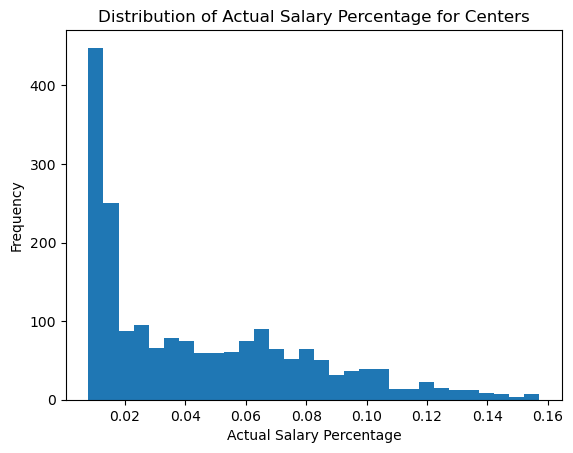

In [666]:
# Plot the distribution of Y_SALARY_CAP_PERCENTAGE
plt.hist(centers['SALARY CAP PERCENTAGE'], bins=30)
plt.xlabel('Actual Salary Percentage')
plt.ylabel('Frequency')
plt.title('Distribution of Actual Salary Percentage for Centers')

In [667]:
# Filter players with over 41 GP
filtered_data = centers[(centers['GP'] > 60) & (centers['SEASON'] == '2023-24')].copy()

# Convert AAV and PRED_SALARY_CAP_AAV back to float
filtered_data['AAV'] = invert_convert_to_dollars(filtered_data, 'AAV')
filtered_data['PRED_AAV'] = invert_convert_to_dollars(filtered_data, 'PRED_AAV')

# Calculate differential between AAV and PRED_SALARY_CAP_AAV
filtered_data['Differential'] = filtered_data['PRED_AAV'] - filtered_data['AAV']

# Sort by differential in descending order
filtered_data = filtered_data.sort_values('Differential', ascending=False)

# Convert AAV and PRED_SALARY_CAP_AAV back to $
filtered_data['AAV'] = convert_to_dollars(filtered_data, 'AAV')
filtered_data['PRED_AAV'] = convert_to_dollars(filtered_data, 'PRED_AAV')

# Select top 5 players with largest differentials
top_players = filtered_data.head(10)

top_players[['TEAM'] + display_features + ['Differential']]

,TEAM,PLAYER,SEASON,GP,TOTAL ASSISTS/60,GOALS/60,SCF/60,FF/60,HDCF/60,CF/60,...,XGF/60,GF/60,ON THE FLY STARTS/60,OFF. ZONE FACEOFFS/60,HDGF/60,SALARY CAP PERCENTAGE,PRED_SALARY_PERCENTAGE,AAV,PRED_AAV,Differential
12849,car,seth jarvis,2023-24,70,1.38,1.19,33.81,50.70,14.32,71.71,...,3.78,4.50,33.31,26.52,2.02,0.010709,0.080128,"$1,394,167.00","$6,690,722.00",5296555.0
12398,fla,evan rodrigues,2023-24,67,1.50,0.58,34.85,55.43,14.97,77.04,...,3.89,3.47,41.09,24.04,2.02,0.035928,0.098288,"$3,000,000.00","$8,207,066.00",5207066.0
12506,min,joel eriksson ek,2023-24,66,1.37,1.28,36.27,52.44,15.51,71.92,...,4.29,4.63,25.87,26.93,1.98,0.062874,0.096753,"$5,250,000.00","$8,078,856.00",2828856.0
12705,ari,nick bjugstad,2023-24,68,1.07,0.86,27.92,42.05,11.34,57.06,...,3.12,3.20,39.31,17.19,1.22,0.025150,0.056120,"$2,100,000.00","$4,686,000.00",2586000.0
12629,wpg,mark scheifele,2023-24,62,1.96,1.05,33.88,49.40,14.23,68.09,...,3.92,4.50,31.29,31.58,2.49,0.073353,0.098489,"$6,125,000.00","$8,223,813.00",2098813.0
12619,min,marco rossi,2023-24,70,0.88,0.94,31.65,48.17,13.04,67.40,...,3.28,2.75,40.64,22.19,1.46,0.010339,0.044598,"$1,713,333.00","$3,723,967.00",2010634.0
12296,col,casey mittelstadt,2023-24,67,1.73,0.79,30.93,49.04,12.27,65.46,...,3.43,4.30,34.69,27.66,1.39,0.029940,0.045192,"$2,500,000.00","$3,773,520.00",1273520.0
12298,vgk,chandler stephenson,2023-24,65,1.35,0.75,27.70,44.17,11.68,61.39,...,3.24,3.19,35.58,26.95,1.55,0.032934,0.044662,"$2,750,000.00","$3,729,269.00",979269.0
12294,fla,carter verhaeghe,2023-24,69,1.74,1.45,45.34,61.39,19.04,87.24,...,4.89,5.08,37.94,29.15,2.56,0.049900,0.060856,"$4,166,667.00","$5,081,473.00",914806.0
12759,vgk,paul cotter,2023-24,65,1.07,0.50,28.93,41.22,11.07,59.22,...,2.70,2.29,42.79,16.93,1.21,0.009281,0.020160,"$775,000.00","$1,683,393.00",908393.0


In [668]:
# Show all players who have a negative differential
filtered_data[filtered_data['Differential'] < 0][['TEAM'] + display_features + ['Differential']]

,TEAM,PLAYER,SEASON,GP,TOTAL ASSISTS/60,GOALS/60,SCF/60,FF/60,HDCF/60,CF/60,...,XGF/60,GF/60,ON THE FLY STARTS/60,OFF. ZONE FACEOFFS/60,HDGF/60,SALARY CAP PERCENTAGE,PRED_SALARY_PERCENTAGE,AAV,PRED_AAV,Differential
12866,tbl,steven stamkos,2023-24,66,1.79,1.34,36.67,51.46,13.50,72.06,...,4.03,4.76,34.04,29.58,1.79,0.101796,0.101266,"$8,500,000.00","$8,455,741.00",-44259.0
12828,van,sam lafferty,2023-24,67,0.82,0.82,24.58,36.19,10.49,52.30,...,2.44,2.62,60.17,15.29,1.87,0.013772,0.013217,"$1,150,000.00","$1,103,591.00",-46409.0
12678,cgy,mikael backlund,2023-24,68,1.05,0.68,29.40,46.67,12.03,63.53,...,3.58,3.10,38.42,16.59,1.60,0.064072,0.063502,"$5,350,000.00","$5,302,385.00",-47615.0
12878,ott,tim stützle,2023-24,68,1.96,0.71,36.41,53.17,14.30,74.36,...,3.96,3.71,41.71,24.86,1.75,0.100000,0.099277,"$8,350,000.00","$8,289,667.00",-60333.0
12385,van,elias lindholm,2023-24,70,1.17,0.56,29.14,45.07,12.04,62.98,...,3.38,2.85,35.74,27.15,1.17,0.058084,0.057107,"$4,850,000.00","$4,768,468.00",-81532.0
12314,wpg,cole perfetti,2023-24,63,1.18,0.97,28.07,48.45,11.92,67.03,...,3.05,3.40,46.37,25.51,1.66,0.010709,0.017854,"$1,627,500.00","$1,490,813.00",-136687.0
12574,fla,kevin stenlund,2023-24,68,0.28,0.70,16.95,31.86,7.21,45.45,...,2.04,1.47,50.35,12.96,0.56,0.011976,0.010160,"$1,000,000.00","$848,335.00",-151665.0
12227,tor,auston matthews,2023-24,67,1.36,2.42,42.82,57.34,19.50,78.20,...,4.64,5.31,34.66,27.40,2.63,0.139404,0.137511,"$11,640,250.00","$11,482,197.00",-158053.0
12799,stl,robert thomas,2023-24,70,2.04,0.94,34.67,48.89,13.61,66.88,...,3.92,3.92,28.66,26.29,1.84,0.097305,0.095257,"$8,125,000.00","$7,953,966.00",-171034.0
12528,cgy,jonathan huberdeau,2023-24,67,1.75,0.46,35.74,52.46,14.19,74.52,...,3.98,3.29,42.63,31.52,1.65,0.125749,0.123696,"$10,500,000.00","$10,328,579.00",-171421.0


In [ ]:
# Truncate the lowest valued predictions to the minimum value for each season

# Step 1: Group the data by 'SEASON' and find the minimum value of 'Y_SALARY_CAP_PERCENTAGE' for each season
min_salary_by_season = centers.groupby('SEASON')['SALARY CAP PERCENTAGE'].min()

# Step 2: Merge the minimum values back into the original dataframe based on the 'SEASON' column
centers = centers.merge(min_salary_by_season, on='SEASON', suffixes=('', '_MIN'))

# Step 3: Update the predictions in 'PRED_SALARY_PERCENTAGE' column if they are lower than the minimum value
centers['PRED_SALARY_PERCENTAGE'] = centers.apply(lambda row: max(row['PRED_SALARY_PERCENTAGE'], row['SALARY CAP PERCENTAGE_MIN']), axis=1)

# Step 4: Update the 'PRED_SALARY_PERCENTAGE' column in the dataframe with the updated predictions
centers['PRED_SALARY_PERCENTAGE'] = centers['PRED_SALARY_PERCENTAGE']
